In [1]:
import random, os, math
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pandas as pd

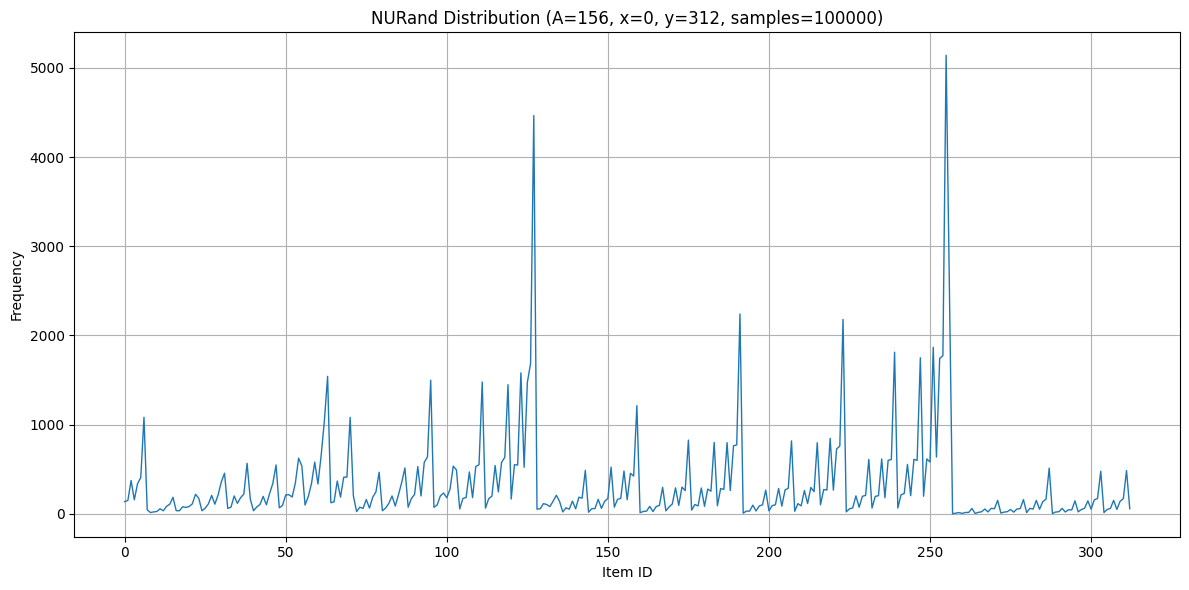

In [2]:
def nurand(A, x, y):
    """Simulate the TPC-C NURand(A, x, y) function."""
    rand1 = random.randint(0, A)
    rand2 = random.randint(x, y)
    return ((rand1 | rand2) % (y - x + 1)) + x

# Parameters
A = int(312 * 0.5)  # skew factor (try 0 for uniform, or 255, 1023, etc. for skew)
x = 0
y = 312
samples = 100_000

# Sampling
results = [nurand(A, x, y) for _ in range(samples)]
counts = Counter(results)

# Sort by item ID
item_ids = sorted(counts.keys())
frequencies = [counts[i] for i in item_ids]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(item_ids, frequencies, linewidth=1)
plt.title(f"NURand Distribution (A={A}, x={x}, y={y}, samples={samples})")
plt.xlabel("Item ID")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

Throughput for Detock meeting per Skew:
- {0.0: '50600.70', 0.0001: '49950.73', 0.001: '51079.67', 0.01: '41015.97', 0.1: '39508.65', 0.5: '39437.17', 1.0: '39099.30'}
Throughput for slog meeting per Skew:
- {0.0: '47912.65', 0.0001: '47147.43', 0.001: '50848.25', 0.01: '39070.13', 0.1: '39424.67', 0.5: '39969.40', 1.0: '39218.23'}
Throughput for janus meeting per Skew:
- {0.0: '9587.57', 0.0001: '6479.12', 0.001: '9644.60', 0.01: '6941.58', 0.1: '8438.95', 0.5: '8468.27', 1.0: '12645.37'}
Throughput for calvin meeting per Skew:
- {0.0: '38572.43', 0.0001: '38759.72', 0.001: '37366.78', 0.01: '32663.25', 0.1: '32716.02', 0.5: '32845.32', 1.0: '31735.12'}


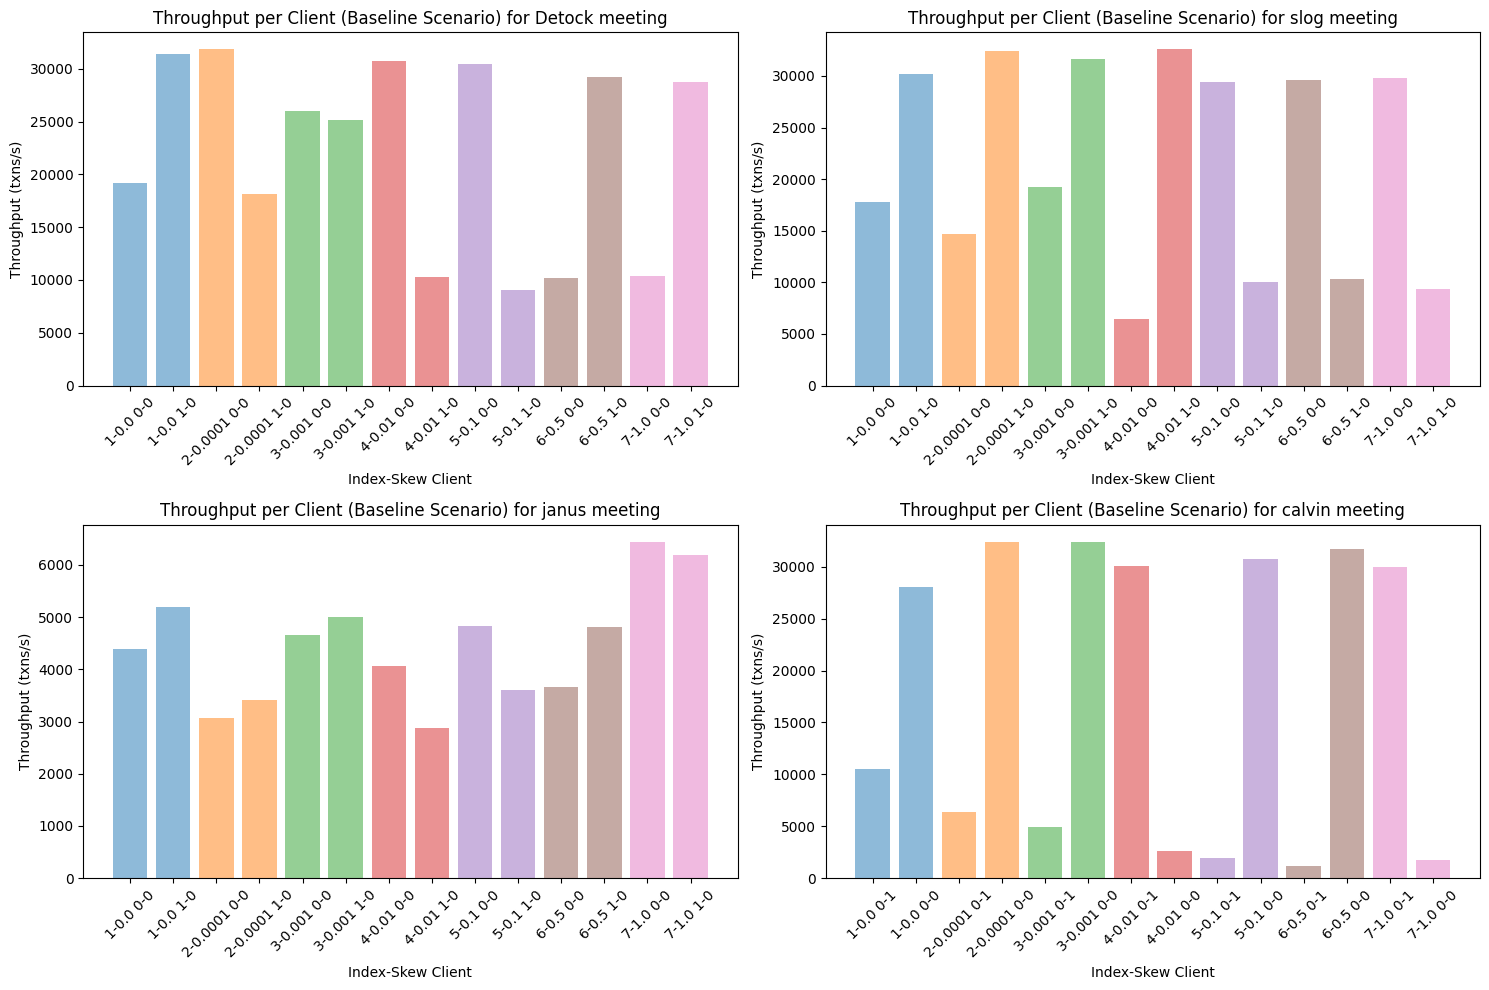

In [20]:
# Skew Scenario Throughput Analysis

# Variables that need to be set
trials = {
    "Detock": ["meeting"],
    "slog": ["meeting"],
    "janus": ["meeting"],
    "calvin": ["meeting"],
}
cols = 2
rows = int(np.ceil(sum([len(x) for x in trials.values()]) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  

i = 0
for db in trials.keys():
    for trial_tag in trials[db]:    
        # Collect throughput data
        skews = defaultdict(dict)
        base_dir = f"../../data/pps/skew/{trial_tag}/{db}"
        for experiment in os.listdir(base_dir):
            skew = float(experiment.split("-")[-1])
            index = int(experiment.split("-")[0])
            current = {}
            for client in os.listdir(f"{base_dir}/{experiment}/client"):
                if os.path.isdir(f"{base_dir}/{experiment}/client/{client}"):
                    metadata = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/metadata.csv")
                    summary = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/summary.csv")

                    duration = metadata["duration"].sum()
                    throughput = summary["committed"].sum() / duration
                    current[client] = throughput
            skews[skew][index] = current

        # Plot the throughput for each experiment per client
        for skew in sorted(skews.keys()):
            for index in sorted(skews[skew].keys()):
                current = skews[skew][index]
                axes[i].bar([f"{index}-{skew} {client}" for client in current.keys()], current.values(), alpha=0.5)
        axes[i].set_title(f"Throughput per Client (Baseline Scenario) for {db} {trial_tag}")
        axes[i].set_xlabel("Index-Skew Client")
        axes[i].set_ylabel("Throughput (txns/s)")
        axes[i].tick_params(axis='x', rotation=45)

        # Print the total average throughput for each skew
        print(f"Throughput for {db} {trial_tag} per Skew:")
        throughput = {}
        for skew in sorted(skews.keys()):
            total = 0
            for index in sorted(skews[skew].keys()):
                current = skews[skew][index]
                total += sum(current.values())
            throughput[skew] = total / len(skews[skew])
        print("-", {skew: f"{v:.2f}" for skew, v in throughput.items()})

        i += 1
plt.tight_layout()
plt.show()

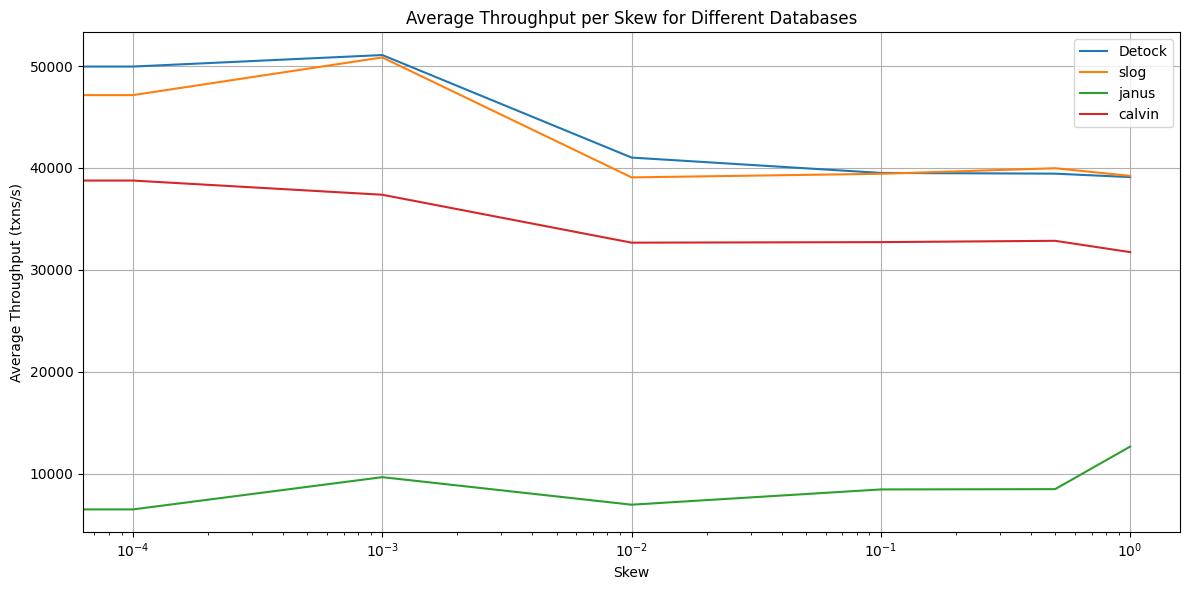

In [15]:
# Skew Scenario Throughput Analysis

# Variables that need to be set
trials = {
    "Detock": ["meeting"],
    "slog": ["meeting"],
    "janus": ["meeting"],
    "calvin": ["meeting"],
}

i = 0
results = {}
for db in trials.keys():
    results[db] = {}
    for trial_tag in trials[db]:    
        # Collect throughput data
        skews = defaultdict(dict)
        base_dir = f"../../data/pps/skew/{trial_tag}/{db}"
        for experiment in os.listdir(base_dir):
            skew = float(experiment.split("-")[-1])
            index = int(experiment.split("-")[0])
            current = {}
            for client in os.listdir(f"{base_dir}/{experiment}/client"):
                if os.path.isdir(f"{base_dir}/{experiment}/client/{client}"):
                    metadata = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/metadata.csv")
                    summary = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/summary.csv")

                    duration = metadata["duration"].sum()
                    throughput = summary["committed"].sum() / duration
                    current[client] = throughput
            skews[skew][index] = current

        # Print the total average throughput for each skew
        for skew in sorted(skews.keys()):
            total = 0
            for index in sorted(skews[skew].keys()):
                current = skews[skew][index]
                total += sum(current.values())
            results[db][skew] = total / len(skews[skew])

        i += 1

# Plot in a single plot the throughput for each database
plt.figure(figsize=(12, 6))
for db, skews in results.items():
    plt.plot(sorted(skews.keys()), list(skews.values()), label=db)
plt.title("Average Throughput per Skew for Different Databases")
plt.xlabel("Skew")
# Log scale for skew
plt.xscale("log")
plt.ylabel("Average Throughput (txns/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# Skew Scenario Record Access Analysis

# Variables that need to be set
trial_tag = "meeting"
samples = 10000
db = "Detock"

base_dir = f"../../data/pps/skew/{trial_tag}/{db}"
experiments = os.listdir(base_dir)
experiments = sorted(experiments, key=lambda x: float(x.split("-")[-1]))

record_access = {}
for i, experiment in enumerate(experiments):
    print(f"Processing {experiment}...")
    # Collecting transaction codes
    codes = {}
    for client in os.listdir(f"{base_dir}/{experiment}/client"):
        if os.path.isdir(f"{base_dir}/{experiment}/client/{client}"):
            transactions = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/transactions.csv")
            codes[client] = transactions["code"].tolist()[:samples]

    # Collecting product access data for get_parts_by_product
    gpbp_type = {}
    for client in codes.keys():
        gpbp_type[client] = []
        for code in codes[client]:
            type = code.split(";")[0]
            if type == "get_parts_by_product":
                gpbp_type[client].append(int(code.split(";")[1]))
    record_access[experiment] = gpbp_type

Processing 1-0...
Processing 2-0.0001...
Processing 3-0.001...
Processing 4-0.01...
Processing 5-0.1...
Processing 6-0.5...
Processing 7-1.0...


In [9]:
# Variables that need to be set
num_regions = 2
num_partitions = 2
num_categories = 4

# Compute the categories of the accessed products and their counts
for experiment, gpbp_type in record_access.items():
    print(f"Experiment: {experiment}")
    for client, product_ids in gpbp_type.items():
        results = {category: defaultdict(Counter) for category in range(num_categories)}
        for product_id in product_ids:
            category = ((product_id - 1) % (num_regions * num_partitions * 4)) // (num_regions * num_partitions)
            chosen_region = (((product_id - 1) % (num_regions * num_partitions * 4)) % (num_regions * num_partitions)) // num_partitions
            chosen_partition = (((product_id - 1) % (num_regions * num_partitions * 4)) % (num_regions * num_partitions)) % num_partitions
            chosen_block_within_cateogory = (product_id - 1)  // (num_regions * num_partitions * 4)
            results[category][(chosen_region, chosen_partition)][chosen_block_within_cateogory] += 1
        print("- Client:", client)
        for category, result in results.items():
            print(f"-- Category {category}:")
            for (region, partition) in sorted(result.keys()):
                counts = result[(region, partition)]
                print(f"--- ({region}, {partition}):", sum(counts.values()), counts.most_common(5))


Experiment: 1-0
- Client: 0-0
-- Category 0:
--- (0, 0): 367 [(22, 5), (140, 5), (122, 4), (172, 4), (6, 4)]
--- (0, 1): 398 [(150, 5), (9, 4), (227, 4), (17, 4), (91, 4)]
--- (1, 0): 383 [(96, 5), (232, 5), (64, 5), (32, 5), (147, 5)]
--- (1, 1): 363 [(310, 5), (226, 5), (20, 5), (52, 4), (255, 4)]
-- Category 1:
--- (0, 0): 385 [(193, 5), (87, 4), (95, 4), (157, 4), (307, 4)]
--- (0, 1): 388 [(233, 5), (113, 5), (36, 5), (145, 5), (217, 4)]
--- (1, 0): 368 [(151, 5), (101, 5), (298, 5), (244, 4), (181, 4)]
--- (1, 1): 361 [(55, 5), (130, 5), (54, 5), (270, 5), (297, 4)]
-- Category 2:
--- (0, 0): 383 [(276, 5), (163, 5), (173, 5), (241, 5), (12, 4)]
--- (0, 1): 375 [(32, 5), (241, 5), (242, 4), (0, 4), (239, 4)]
--- (1, 0): 377 [(3, 7), (134, 5), (14, 5), (171, 5), (210, 5)]
--- (1, 1): 368 [(115, 5), (58, 5), (39, 4), (12, 4), (88, 4)]
-- Category 3:
--- (0, 0): 377 [(229, 4), (273, 4), (233, 4), (198, 4), (106, 4)]
--- (0, 1): 375 [(41, 6), (26, 4), (137, 4), (75, 4), (286, 4)]
---

In [39]:
# Skew Scenario Involved Regions and Partitions Analysis

# Variables that need to be set
trial_tags = ["trial-mh_100-mp_50-1"]
samples = 10000

for i, trial_tag in enumerate(trial_tags):
    # Collecting involved regions and partitions data
    print(f"Processing {trial_tag}...")
    base_dir = f"../../data/pps/skew/{trial_tag}/Detock"
    involved_regions = defaultdict(dict)
    involved_partitions = defaultdict(dict)
    for experiment in os.listdir(base_dir):
        skew = float(experiment.split("-")[-1])
        index = int(experiment.split("-")[0])
        involved_regions[skew][index] = {}
        involved_partitions[skew][index] = {}
        for client in os.listdir(f"{base_dir}/{experiment}/client"):
            if os.path.isdir(f"{base_dir}/{experiment}/client/{client}"):
                transactions = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/transactions.csv")
                involved_regions[skew][index][client] = dict(Counter([x for x in transactions["regions"][:samples].values \
                                                 if not isinstance(x, float) or not math.isnan(x)]))
                involved_partitions[skew][index][client] = dict(Counter([x for x in transactions["partitions"][:samples].values \
                                                    if not isinstance(x, float) or not math.isnan(x)]))
    
    # Print the involved regions and partitions for each skew
    for skew in sorted(involved_regions.keys()):
        print(f"- Results for Skew {skew}")
        for index in sorted(involved_regions[skew].keys()):
            current = involved_regions[skew][index]
            print(f"-- {index} Reg:", 
                  {client: {regions: f"{current[client][regions]} ({int(current[client][regions] / sum(current[client].values()) * 100)}%)" \
                    for regions in sorted(current[client])} for client in current})
            # current = involved_partitions[skew][index]
            # print(f"--- Partitions:", 
            #       {client: {partitions: f"{current[client][partitions]} ({int(current[client][partitions] / sum(current[client].values()) * 100)}%)" \
            #         for partitions in current[client]} for client in current})

Processing trial-mh_100-mp_50-1...
- Results for Skew 0.0
-- 1 Reg: {'0-0': {'0': '3482 (34%)', '0;1': '3071 (30%)', '1': '3417 (34%)'}, '1-0': {'0': '3497 (35%)', '0;1': '3000 (30%)', '1': '3432 (34%)'}}
- Results for Skew 0.0001
-- 2 Reg: {'0-0': {'0': '3456 (34%)', '0;1': '3009 (30%)', '1': '3488 (35%)'}, '1-0': {'0': '3523 (35%)', '0;1': '2975 (30%)', '1': '3418 (34%)'}}
- Results for Skew 0.001
-- 3 Reg: {'0-0': {'0': '3484 (34%)', '0;1': '2990 (30%)', '1': '3484 (34%)'}, '1-0': {'0': '3380 (34%)', '0;1': '3058 (30%)', '1': '3487 (35%)'}}
- Results for Skew 0.01
-- 4 Reg: {'0-0': {'0': '3412 (34%)', '0;1': '2962 (30%)', '1': '3475 (35%)'}, '1-0': {'0': '3523 (35%)', '0;1': '2975 (29%)', '1': '3450 (34%)'}}
- Results for Skew 0.1
-- 5 Reg: {'0-0': {'0': '3446 (34%)', '0;1': '2930 (29%)', '1': '3510 (35%)'}, '1-0': {'0': '3482 (34%)', '0;1': '2905 (29%)', '1': '3562 (35%)'}}
- Results for Skew 0.5
-- 6 Reg: {'0-0': {'0': '3479 (35%)', '0;1': '2946 (29%)', '1': '3460 (35%)'}, '1-0': 

In [41]:
# Skew Scenario Record Access Analysis

# Variables that need to be set
trial_tag = "trial-mh_100-mp_50-1"
samples = 10000

base_dir = f"../../data/pps/skew/{trial_tag}/Detock"
experiments = os.listdir(base_dir)
experiments = sorted(experiments, key=lambda x: float(x.split("-")[-1]))

record_access = {}
for i, experiment in enumerate(experiments):
    print(f"Processing {experiment}...")
    # Collecting transaction codes
    codes = {}
    for client in os.listdir(f"{base_dir}/{experiment}/client"):
        if os.path.isdir(f"{base_dir}/{experiment}/client/{client}"):
            transactions = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/transactions.csv")
            codes[client] = transactions["code"].tolist()[:samples]

    # Collecting product access data for get_parts_by_product
    gpbp_type = {}
    for client in codes.keys():
        gpbp_type[client] = []
        for code in codes[client]:
            type = code.split(";")[0]
            if type == "get_parts_by_product":
                gpbp_type[client].append(int(code.split(";")[1]))
    record_access[experiment] = gpbp_type

Processing 1-0...
Processing 2-0.0001...
Processing 3-0.001...
Processing 4-0.01...
Processing 5-0.1...
Processing 6-0.5...
Processing 7-1.0...


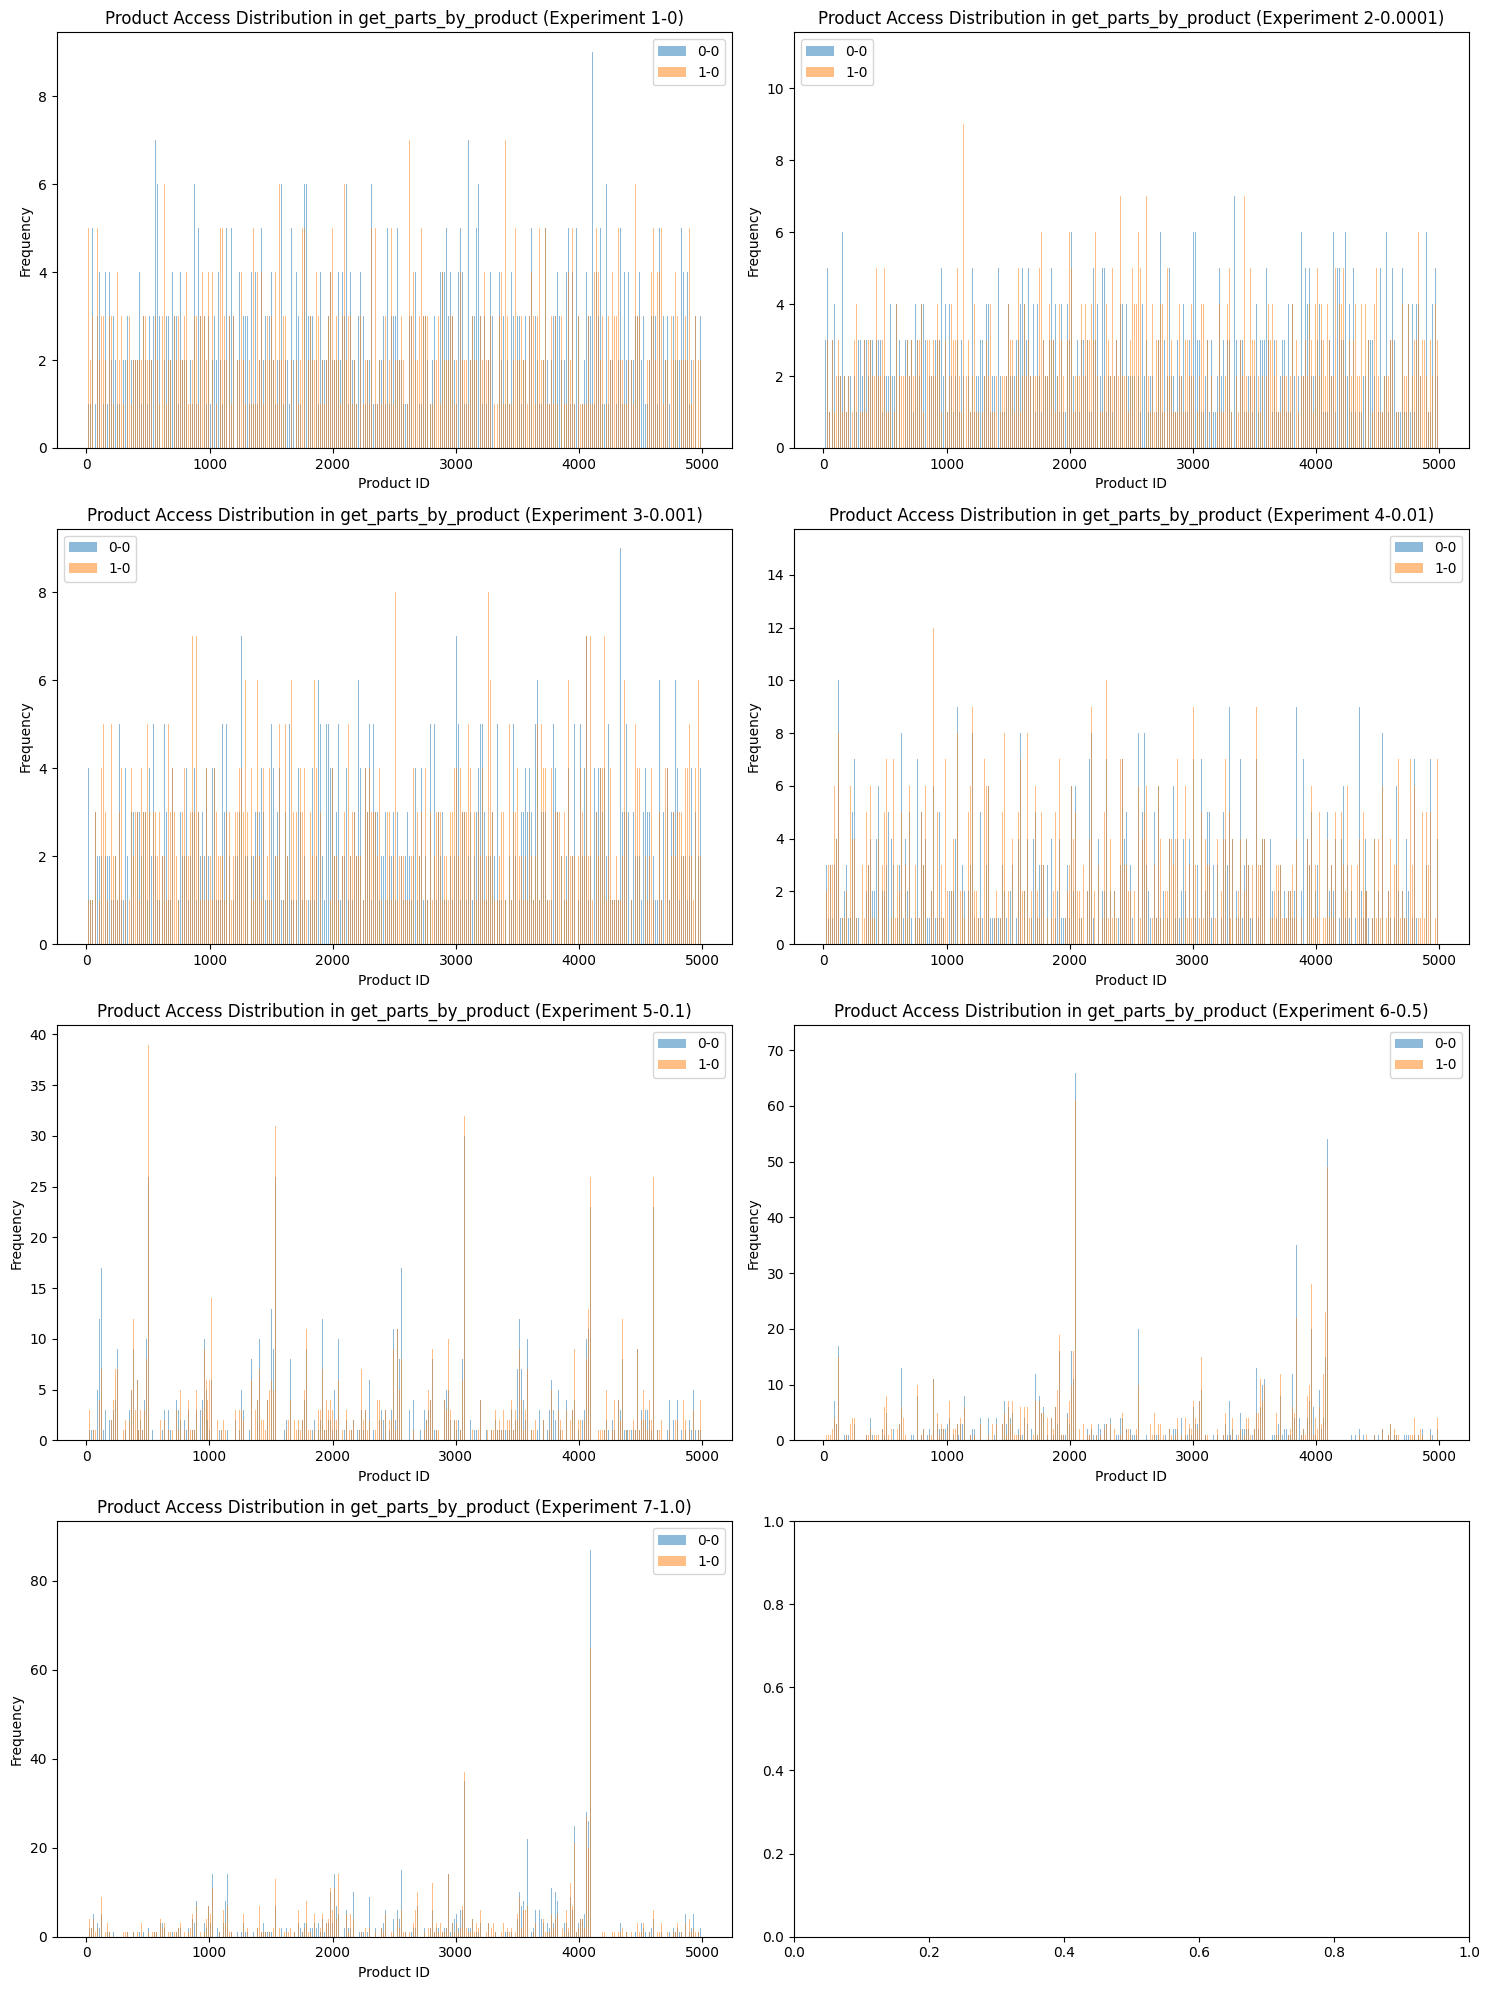

In [42]:
# Variables that need to be set
cols = 2

rows = int(np.ceil(len(experiments) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  

# Plot the product access distribution for each experiment for get_parts_by_product
for i, experiment in enumerate(experiments):
    gpbp_type = record_access[experiment]
    for j, client in enumerate(gpbp_type.keys()):
        mn = min(gpbp_type[client])
        mx = max(gpbp_type[client])
        axes[i].hist(gpbp_type[client], bins=range(mn, mx + 1), alpha=0.5, label=client)
    axes[i].set_title(f"Product Access Distribution in get_parts_by_product (Experiment {experiment})")
    axes[i].set_xlabel("Product ID")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()
plt.tight_layout()
plt.show()

In [43]:
# Print the most accessed products
for experiment in experiments:
    gpbp_type = record_access[experiment]
    print(f"Most accessed products for {experiment}:")
    counters = {}
    for client in gpbp_type.keys():
        counter = Counter(gpbp_type[client])
        counters[client] = counter
        most_common = counter.most_common(25)
        print(f"- {client}: {most_common}")
    intersection = set(gpbp_type[list(gpbp_type.keys())[0]])
    for client in gpbp_type.keys():
        intersection = intersection.intersection(set(gpbp_type[client]))
    print(f"- Intersection:", {product: [counters[client][product] for client in gpbp_type.keys()] for product in intersection})

Most accessed products for 1-0:
- 0-0: [(3807, 9), (4108, 9), (2299, 8), (672, 8), (3738, 7), (3900, 7), (1613, 7), (713, 7), (2144, 7), (4383, 7), (2458, 7), (3101, 7), (41, 7), (3833, 7), (1886, 7), (1935, 7), (4265, 7), (395, 7), (1487, 7), (2000, 7), (560, 7), (3182, 6), (2957, 6), (816, 6), (1257, 6)]
- 1-0: [(1133, 9), (1116, 8), (1882, 8), (2639, 8), (3837, 7), (1995, 7), (2172, 7), (480, 7), (1309, 7), (4653, 7), (829, 7), (2622, 7), (2191, 7), (2848, 7), (3007, 7), (2413, 7), (3757, 7), (639, 7), (3402, 7), (1597, 7), (4605, 7), (1530, 7), (4795, 7), (302, 7), (4190, 7)]
- Intersection: {10: [4, 1], 11: [3, 2], 12: [4, 3], 13: [1, 1], 14: [3, 3], 15: [2, 4], 16: [1, 5], 25: [3, 3], 26: [5, 2], 27: [4, 1], 28: [3, 3], 29: [2, 6], 30: [1, 1], 32: [1, 2], 41: [7, 2], 42: [1, 4], 43: [3, 4], 45: [2, 3], 46: [1, 1], 47: [2, 3], 48: [5, 3], 57: [1, 1], 61: [4, 4], 63: [2, 2], 64: [4, 2], 74: [6, 3], 76: [5, 1], 77: [2, 3], 79: [3, 4], 80: [3, 1], 89: [3, 5], 90: [2, 1], 92: [2, 5], 